In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import h5py
from mpl_toolkits.axes_grid1 import make_axes_locatable
# from subhalo_count import *

# mpl.rcParams.update(mpl.rcParamsDefault)
# plt.style.use('/home/aussing/sty.mplstyle')

In [2]:
UNITMASS = 1e10
LITTLEH = 0.6688
UNIT_LENGTH_FOR_PLOTS = 'Mpc'
npart_min = 20
npart_star_min = 1


In [3]:

def get_extent(halo_pos,extent):

    xmin,xmax  = halo_pos[0]-extent,halo_pos[0]+extent
    ymin,ymax  = halo_pos[1]-extent,halo_pos[1]+extent
    zmin,zmax  = halo_pos[2]-extent,halo_pos[2]+extent
    
    return xmin,xmax,ymin,ymax,zmin,zmax


In [4]:

def make_mask(pos_x,pos_y,pos_z,halo_pos,extent):
    xmin,xmax,ymin,ymax,zmin,zmax = get_extent(halo_pos,extent)
    
    x_mask = (pos_x>=xmin) & (pos_x<=xmax)
    y_mask = (pos_y>=ymin) & (pos_y<=ymax)
    z_mask = (pos_z>=zmin) & (pos_z<=zmax)
    
    pos_mask = x_mask & y_mask & z_mask

    return pos_mask

In [5]:
def get_sim_data(sim_directory,n_file):
    snap_fname     = f'/snapshot_{str(n_file).zfill(3)}.hdf5'
    snap_directory = sim_directory + snap_fname
    snap_data     = h5py.File(snap_directory, 'r')
    
    # haloinfo_fname     = f'/fof_tab_{str(i_file).zfill(3)}.hdf5'
    haloinfo_fname     = f'/fof_subhalo_tab_{str(n_file).zfill(3)}.hdf5'
    haloinfo_directory = sim_directory + haloinfo_fname
    haloinfo_data = h5py.File(haloinfo_directory, 'r')

    z = np.round(snap_data['Header'].attrs['Redshift'],2)
    return snap_data, haloinfo_data, z

In [6]:
def subhalo_data(sim_directory,i_file):
    snap_data, haloinfo_data, z = get_sim_data(sim_directory,i_file)
    z = np.round(z,2)
    print(z)
    # unit_len = get_unit_len(snap_data)

    halo_pos   = np.array(haloinfo_data['Group']['GroupPos'], dtype=np.float64) / LITTLEH
    halo_mass  = np.array(haloinfo_data['Group']['GroupMass'], dtype=np.float64) * UNITMASS / LITTLEH
    halo_M200c = np.array(haloinfo_data['Group']['Group_M_Crit200'], dtype=np.float64) * UNITMASS / LITTLEH
    halo_masstypes = np.array(haloinfo_data['Group']['GroupMassType'], dtype=np.float64) * UNITMASS / LITTLEH
    R200c = np.array(haloinfo_data['Group']['Group_R_Crit200'], dtype=np.float64) / LITTLEH

    mass_mask = np.argsort(halo_M200c)[::-1]
    halo_mainID = np.where(halo_masstypes[mass_mask,5] == 0)[0][0]

    # print(f"Redshift = {np.round(z,2)}")
    # print(f"main halo ID = {mass_mask[halo_mainID]}")
    # print(f"Main halo pos = {halo_pos[mass_mask[halo_mainID],:]*LITTLEH}")
    # print(f'M_200c = {np.round(halo_M200c[mass_mask[halo_mainID]]/1e10,3)*LITTLEH}e10 h^-1 Msun')
    # print(f"R_200c = {np.round((R200c[mass_mask[halo_mainID]]),4)*LITTLEH} {UNIT_LENGTH_FOR_PLOTS}") # *unit_len set_plot_len

    main_halo_only = True
    subhalo_halo_num = np.array(haloinfo_data['Subhalo']['SubhaloGroupNr'], dtype=np.float64)
    subhalo_rank       = np.array(haloinfo_data['Subhalo']['SubhaloRankInGr'], dtype=np.int32)

    subhalo_mass       = np.array(haloinfo_data['Subhalo']['SubhaloMass'],dtype=np.float64) * UNITMASS / LITTLEH
    subhalo_mass_type  = np.array(haloinfo_data['Subhalo']['SubhaloMassType'],dtype=np.float64) * UNITMASS / LITTLEH
    subhalo_len        = np.array(haloinfo_data['Subhalo']['SubhaloLen'],dtype=np.int32)
    subhalo_len_type   = np.array(haloinfo_data['Subhalo']['SubhaloLenType'],dtype=np.int32)
    subhalo_pos        = np.array(haloinfo_data['Subhalo']['SubhaloPos'], dtype=np.float64) / LITTLEH 

    main_halo_subhalos = np.where(subhalo_halo_num==[mass_mask[halo_mainID]])

    subhalo_mass       = subhalo_mass[main_halo_subhalos][subhalo_rank[main_halo_subhalos]!=0] 
    subhalo_mass_type  = subhalo_mass_type[main_halo_subhalos][subhalo_rank[main_halo_subhalos]!=0]
    subhalo_len        = subhalo_len[main_halo_subhalos][subhalo_rank[main_halo_subhalos]!=0]
    subhalo_len_type   = subhalo_len_type[main_halo_subhalos][subhalo_rank[main_halo_subhalos]!=0] 

    subhalo_pos = np.array(haloinfo_data['Subhalo']['SubhaloPos'], dtype=np.float64) / LITTLEH 
    subhalo_pos = subhalo_pos[main_halo_subhalos][subhalo_rank[main_halo_subhalos]!=0]

    # subhalo_pos_dif = subhalo_pos - halo_pos[mass_mask[halo_mainID],:]
    # print(f"subhalo rank 0 - {subhalo_pos[0,:]}")
    # print(f"subhalo rank 1 - {subhalo_pos[1,:]}\n")

    subhalo_dist = []
    for i in range(len(subhalo_pos)):
        # print(positions[i])
        # print((positions-main_halo_pos)[i])
        subhalo_pos_dif = subhalo_pos[i] - halo_pos[mass_mask[halo_mainID],:]
        subhalo_dist.append(np.sqrt(subhalo_pos_dif[0]**2+subhalo_pos_dif[1]**2+subhalo_pos_dif[2]**2))

    subhalo_dist = np.array(subhalo_dist)
    mask_dists = (subhalo_dist>0.01) #& (subhalo_dist<set_plot_len(R200c[mass_mask[halo_mainID]]*unit_len))
    # print(subhalo_dist[mask_dists])
    test = subhalo_dist[mask_dists]

    mask = (subhalo_len>=npart_min) & (subhalo_len_type[:,4]>=npart_star_min) & (subhalo_dist>0.005)  #& (subhalo_dist<set_plot_len(R200c[mass_mask[halo_mainID]]*unit_len))

    # print(mask)
    star_mass              = subhalo_mass_type[mask,4]
    star_mass_ordered      = np.argsort(star_mass)[::-1]
    star_mass              = star_mass[star_mass_ordered][np.where(star_mass[star_mass_ordered]>0)[0]]
    star_mass_sum          = np.cumsum(np.ones(star_mass.shape[0]))
    
    subhalo_radius = np.array(haloinfo_data['Subhalo']['SubhaloHalfmassRad'],dtype=np.float64) #/ LITTLEH #* unit_len
    subhalo_radius = subhalo_radius[main_halo_subhalos][subhalo_rank[main_halo_subhalos]!=0] 
    
    return star_mass, star_mass_sum, z, subhalo_pos, subhalo_radius, R200c[mass_mask[halo_mainID]], subhalo_mass_type

In [7]:
sim_directory_cdm_005 = '/fred/oz217/aussing/N2048_L65_sd46371/cdm/zoom/output/sn_005/'
sim_directory_cdm_010 = '/fred/oz217/aussing/N2048_L65_sd46371/cdm/zoom/output/sn_010/'

sim_directory_wdm_005 = '/fred/oz217/aussing/N2048_L65_sd46371/wdm_3.5/zoom/output/sn_005/'
sim_directory_wdm_010 = '/fred/oz217/aussing/N2048_L65_sd46371/wdm_3.5/zoom/output/sn_010/'
i_file = 26
star_mass_cdm_005, star_mass_sum_cdm_005, z, subhalo_pos_cdm_005, subhalo_radius_cdm_005, r_200c_cdm_005, subhalo_mass_type_cdm_005 = subhalo_data(sim_directory_cdm_005,i_file)
star_mass_cdm_010, star_mass_sum_cdm_010, z, subhalo_pos_cdm_010, subhalo_radius_cdm_010, r_200c_cdm_010, subhalo_mass_type_cdm_010 = subhalo_data(sim_directory_cdm_010,i_file)

star_mass_wdm_005, star_mass_sum_wdm_005, z, subhalo_pos_wdm_005, subhalo_radius_wdm_005, r_200c_wdm_005, subhalo_mass_type_wdm_005 = subhalo_data(sim_directory_wdm_005,i_file)
star_mass_wdm_010, star_mass_sum_wdm_010, z, subhalo_pos_wdm_010, subhalo_radius_wdm_010, r_200c_wdm_010, subhalo_mass_type_wdm_010 = subhalo_data(sim_directory_wdm_010,i_file)

0.0
0.0
0.0
0.0


In [8]:
def AHF_data(ahf_halos):
    ahf_cols = []
    with open(ahf_halos) as ahf_f:
        aux_ahf_cols = ahf_f.readline()[1:].split('\t')
        for el in aux_ahf_cols:
            ahf_cols.append(el.rpartition('(')[0])
    ahf_cols = ahf_cols[:-1]
    ahf_cols = np.array(ahf_cols)

    ahf_dat = pd.read_table(ahf_halos,delim_whitespace=True,names=ahf_cols,header=0)

    # print(np.sort(ahf_cols[:]))
    
    mainhaloes = ahf_dat[(ahf_dat['hostHalo']==0) & (ahf_dat['fMhires']==1) & (ahf_dat['npart']>npart_min)].sort_values('Mhalo',ascending=False)

    halo_mass_ahf = mainhaloes['Mhalo'] / LITTLEH
    main_halo_pos = np.array((mainhaloes['Xc'].iloc[0] ,mainhaloes['Yc'].iloc[0] / 1,mainhaloes['Zc'].iloc[0] / 1)) / 1e3 / LITTLEH
    # print(f"AHF halo mass = {mainhaloes['Mhalo'].iloc[0] / LITTLEH / UNITMASS }e10 Msun")
    # print(f"AHF halo radius = {mainhaloes['Rhalo'].iloc[0] / LITTLEH / 1e3} Mpc")
    # print(f"AHF halo pos = {main_halo_pos}")

    subhaloes = ahf_dat[(ahf_dat['hostHalo']!=0) & (ahf_dat['fMhires']==1) & (ahf_dat['npart']>npart_min)]
    print(len(subhaloes))
    MH_subhaloes = subhaloes[subhaloes['hostHalo']==mainhaloes['ID'].iloc[0]]
    print(len(MH_subhaloes))
    xpos = MH_subhaloes['Xc'] / 1e3 / LITTLEH   # [MH_subhaloes['M_star']>0]
    ypos = MH_subhaloes['Yc'] / 1e3 / LITTLEH   # [MH_subhaloes['M_star']>0]
    zpos = MH_subhaloes['Zc'] / 1e3 / LITTLEH   # [MH_subhaloes['M_star']>0]
    positions = np.column_stack((xpos,ypos,zpos)) 
    subhalo_dist = []
    for i in range(len(positions)):
        # print(positions[i])
        # print((positions-main_halo_pos)[i])
        subhalo_pos_dif = (positions-main_halo_pos)[i]
        subhalo_dist.append(np.sqrt(subhalo_pos_dif[0]**2+subhalo_pos_dif[1]**2+subhalo_pos_dif[2]**2))
        # print()

    
    subhalo_dist = np.array(subhalo_dist)
    # print(subhalo_dist[subhalo_dist>0.01])
    # print(MH_subhaloes['M_star'][MH_subhaloes['M_star']>0][subhalo_dist<0.01])
    
    mask_ahf = (MH_subhaloes['M_star']>0) & (MH_subhaloes['n_star']>=npart_star_min) & (subhalo_dist>0.005) #& (subhalo_dist<mainhaloes['Rhalo'].iloc[0] / LITTLEH / 1e3)
    
    MH_subhaloes_sorted = np.sort(MH_subhaloes['M_star'][mask_ahf])[::-1] / LITTLEH
    subhalo_cummass_func_ahf = np.cumsum(np.ones(len(MH_subhaloes_sorted)))

    # MW_all_subhaloes = np.sort((MH_subhaloes['Mhalo'] - MH_subhaloes['M_star']- MH_subhaloes['M_gas']))[::-1] / LITTLEH # 
    MW_all_subhaloes = np.sort((MH_subhaloes['Mhalo']))[::-1] / LITTLEH # 
    all_subhalo_cummass_func_ahf = np.cumsum(np.ones(len(MW_all_subhaloes)))

    return MH_subhaloes_sorted, subhalo_cummass_func_ahf, MW_all_subhaloes, all_subhalo_cummass_func_ahf

In [9]:
ahf_halos_cdm_005 = '/fred/oz217/aussing/N2048_L65_sd46371/cdm/zoom/output/sn_005/ahf/AHF.N2048_L65_sd46371-sn_005.snap_026.z0.000.AHF_halos'
ahf_halos_cdm_010 = '/fred/oz217/aussing/N2048_L65_sd46371/cdm/zoom/output/sn_010/ahf/AHF.N2048_L65_sd46371-sn_010.snap_026.z0.000.AHF_halos'

ahf_halos_wdm_005 = '/fred/oz217/aussing/N2048_L65_sd46371/wdm_3.5/zoom/output/sn_005/ahf/AHF.N2048_L65_sd46371-sn_005.snap_026.z0.000.AHF_halos'
ahf_halos_wdm_010 = '/fred/oz217/aussing/N2048_L65_sd46371/wdm_3.5/zoom/output/sn_010/ahf/AHF.N2048_L65_sd46371-sn_010.snap_026.z0.000.AHF_halos'

MH_subhaloes_cdm_005,subhalo_cummass_func_ahf_cdm_005, MW_all_subhaloes_cdm_005, all_subhalo_cummass_func_ahf_cdm_005 = AHF_data(ahf_halos_cdm_005)
MH_subhaloes_cdm_010,subhalo_cummass_func_ahf_cdm_010, MW_all_subhaloes_cdm_010, all_subhalo_cummass_func_ahf_cdm_010 = AHF_data(ahf_halos_cdm_010)

MH_subhaloes_wdm_005,subhalo_cummass_func_ahf_wdm_005, MW_all_subhaloes_wdm_005, all_subhalo_cummass_func_ahf_wdm_005 = AHF_data(ahf_halos_wdm_005)
MH_subhaloes_wdm_010,subhalo_cummass_func_ahf_wdm_010, MW_all_subhaloes_wdm_010, all_subhalo_cummass_func_ahf_wdm_010 = AHF_data(ahf_halos_wdm_010)

1584
106
1527
102
539
44
509
39


In [10]:
# vel_out_dir_test = '/fred/oz217/aussing/VELOCIraptor-STF/output/test/'
# vel_halo_data_test = h5py.File(f'{vel_out_dir_test}/test.properties', 'r')
# vel_halo_info_test = h5py.File(f'{vel_out_dir_test}/test.catalog_groups', 'r')
# vel_subhalo_data_test = h5py.File(f'{vel_out_dir_test}/test.sublevels.properties', 'r')
# vel_subhalo_info_test = h5py.File(f'{vel_out_dir_test}/test.sublevels.catalog_groups', 'r')

VR_out_dir_cdm_sn_005 = '/fred/oz217/aussing/VELOCIraptor-STF/output/N2048_L65_sd46371/wdm_sn_005'
vel_halo_data_test = h5py.File(f'{VR_out_dir_cdm_sn_005}/out.properties', 'r')
vel_halo_info_test = h5py.File(f'{VR_out_dir_cdm_sn_005}/out.catalog_groups', 'r')
vel_subhalo_data_test = h5py.File(f'{VR_out_dir_cdm_sn_005}/out.sublevels.properties', 'r')
vel_subhalo_info_test = h5py.File(f'{VR_out_dir_cdm_sn_005}/out.sublevels.catalog_groups', 'r')

In [11]:
num_haloes = np.array(vel_halo_info_test['Num_of_groups'],dtype=int)
pos = [vel_halo_data_test['Xcmbp'][0], vel_halo_data_test['Ycmbp'][0], vel_halo_data_test['Zcmbp'][0]]

num_subhaloes = np.array(vel_halo_info_test['Number_of_substructures_in_halo'],dtype=int)

subhalo_parent_id = np.array(vel_subhalo_info_test['Parent_halo_ID'],dtype=int)-1
test_id = 0
mask = np.where(subhalo_parent_id==test_id)[0]
# print(f"make len = {len(mask)}")
sub_mass = vel_subhalo_data_test['Mass_tot'][mask]*1e10
sub_mass_gas = vel_subhalo_data_test['Mass_gas'][mask]*1e10
sub_mass_star = vel_subhalo_data_test['Mass_star'][mask]*1e10

# print(f"VR stellar mass = {np.sum(sub_mass_star):3e}")
# print(f"SF stellar mass = {np.sum(subhalo_mass_type_cdm_010[:,4]):3e}")


27.300638198852543 35.95769119262695


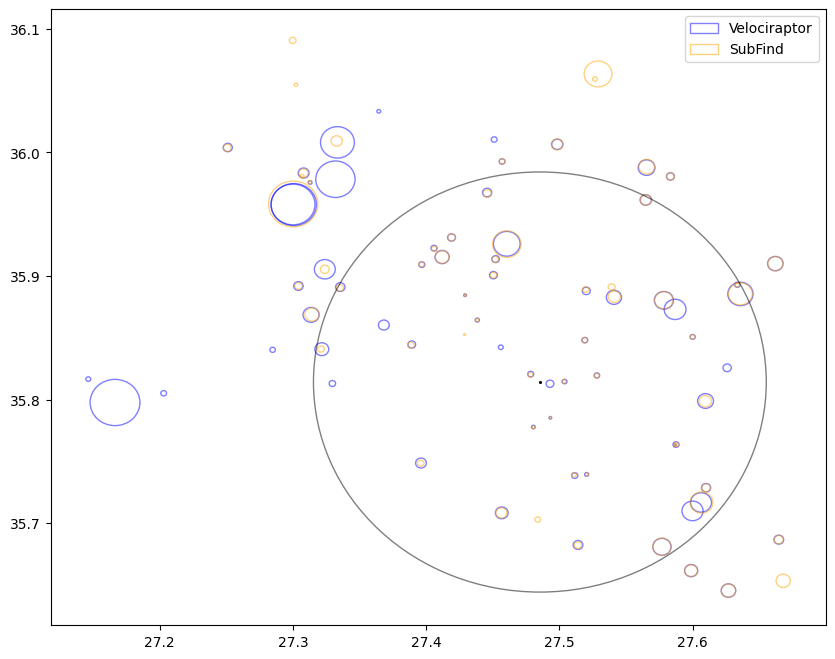

In [18]:
max_sats = len(mask)
# max_sats = 25
npart_gas = vel_subhalo_data_test['n_gas'][mask]
npart_star = vel_subhalo_data_test['n_star'][mask]
npart_tot = vel_subhalo_data_test['npart'][mask]

gas_mask = npart_gas > 0
star_mask = npart_star > 0
baryon_mask = gas_mask | star_mask
# print(np.sum(baryon_mask))
# Vel_sat_pos = np.array((vel_subhalo_data['Xcminpot'][0:max_sats],vel_subhalo_data['Ycminpot'][0:max_sats],vel_subhalo_data['Zcminpot'][0:max_sats]))
Vel_sat_pos = np.array((vel_subhalo_data_test['Xcminpot'][mask],vel_subhalo_data_test['Ycminpot'][mask],vel_subhalo_data_test['Zcminpot'][mask]))
vr_sub_rad = vel_subhalo_data_test['R_HalfMass'][mask]

vr_sub_x_pos_cm = np.array(vel_subhalo_data_test['Xcminpot'][mask])#[baryon_mask])
vr_sub_y_pos_cm = np.array(vel_subhalo_data_test['Ycminpot'][mask])#[baryon_mask])
vr_sub_z_pos_cm = np.array(vel_subhalo_data_test['Zcminpot'][mask])#[baryon_mask])

vr_sub_x_pos = np.array(vel_subhalo_data_test['Xc'][mask][baryon_mask])
vr_sub_y_pos = np.array(vel_subhalo_data_test['Yc'][mask][baryon_mask])
print(vel_subhalo_data_test['Xcminpot'][mask][0],vel_subhalo_data_test['Ycminpot'][mask][0])



fig, ax = plt.subplots(figsize=(10,8))
# ax.add_patch(plt.Circle((vr_sub_x_pos_cm[0],vr_sub_y_pos_cm[0]),vr_sub_rad[0],fill=False,color='blue',alpha=1))
for i in range(len(vr_sub_x_pos_cm)):
    # VR subhaloes
    ax.add_patch(plt.Circle((vr_sub_x_pos_cm[i],vr_sub_y_pos_cm[i]),vr_sub_rad[i],fill=False,color='blue',alpha=0.5))
    # ax.add_patch(plt.Circle((vr_sub_x_pos[i],vr_sub_y_pos[i]),vr_sub_rad[i],fill=False,color='orange',alpha=0.9))

for i in range(len(subhalo_pos_wdm_005[:,0])):
    ## SUBFIND subhaloes
    ax.add_patch(plt.Circle((subhalo_pos_wdm_005[i,0]*LITTLEH,subhalo_pos_wdm_005[i,1]*LITTLEH),subhalo_radius_wdm_005[i],fill=False,color='orange',alpha=0.5))

plt.legend(('Velociraptor','SubFind'))
ax_gce = plt.gca()
leg = ax_gce.get_legend()
leg.legendHandles[0].set_color('blue')
leg.legendHandles[1].set_color('orange')

## VR central halo pos & rad
# plt.plot()
plt.scatter(vel_halo_data_test['Xcminpot'][test_id], vel_halo_data_test['Ycminpot'][test_id],c='k',s=1.5)
rad = vel_halo_data_test["R_200crit"][test_id]
ax.add_patch(plt.Circle((vel_halo_data_test['Xcminpot'][test_id], vel_halo_data_test['Ycminpot'][test_id]),rad, fill=False,color='k',alpha=0.5))
# ax.add_patch(plt.Circle((vel_halo_data['Xc'][test_id], vel_halo_data['Yc'][test_id]),rad, fill=False,color='lime',alpha=0.5))

## subfind halo pos
# subfind_r200c = r_200c_cdm_010*LITTLEH
# ax.add_patch(plt.Circle((27.47050095, 35.81316757),subfind_r200c, fill=False,color='red',alpha=0.5))


# Main halo pos = [27.47050095 35.81316757 32.22106934]
# M_200c = 124.84824e10 h^-1 Msun
# R_200c = 0.17509183999999997 Mpc


In [13]:
plt.close()
n_file = 26
snap_fname     = f'/snapshot_{str(n_file).zfill(3)}.hdf5'
snap_directory = '/fred/oz217/aussing/N2048_L65_sd46371/cdm/zoom/output/sn_010/' + snap_fname
snap_data     = h5py.File(snap_directory, 'r')

dm_part_pos = np.array(snap_data[f'PartType1']['Coordinates'],dtype=np.float64)  #* unit_len  
gas_part_pos = np.array(snap_data[f'PartType0']['Coordinates'],dtype=np.float64)  #* unit_len  
star_part_pos = np.array(snap_data[f'PartType4']['Coordinates'],dtype=np.float64)  #* unit_len  \

dm_part_mass = snap_data['Header'].attrs["MassTable"][1] * UNITMASS #/ LITTLEH 
gas_part_mass = np.array((snap_data[f'PartType0']['Masses']),dtype=np.float64) * UNITMASS #/ LITTLEH 
star_part_mass = np.array((snap_data[f'PartType4']['Masses']),dtype=np.float64) * UNITMASS #/ LITTLEH 

# all_pos = np.vstack((dm_part_pos,gas_part_pos,star_part_pos))
all_pos = dm_part_pos

dm_mass = np.ones((len(dm_part_pos),))*dm_part_mass
# all_mass = np.concatenate((dm_mass,gas_part_mass,star_part_mass),axis=0)
all_mass = dm_mass

halo_pos = (27.47050095, 35.81316757, 32.22106934)
# r200c_subfind = 0.1750918
extent = subfind_r200c * 1.4
pos_mask = make_mask(all_pos[:,0],all_pos[:,1],all_pos[:,2],halo_pos,extent)

all_pos = all_pos[pos_mask]
all_mass = all_mass[pos_mask]


Num Velociraptor subhaloes = 68
Num Subfind subhaloes = 139


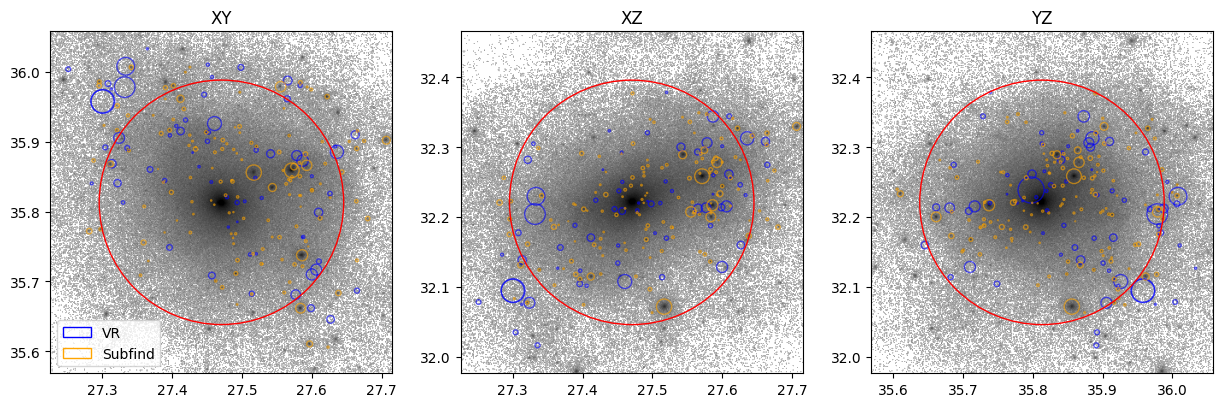

In [14]:
cmap = mpl.cm.get_cmap('gray_r')
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,10))
# fig, (ax1) = plt.subplots(figsize=(15,10))

## particle background
part_hist_xy, edges_x,edges_y = np.histogram2d(all_pos[:,0],all_pos[:,1],bins=400,weights=all_mass)
edges = np.array((np.min(edges_x),np.max(edges_x),np.min(edges_y),np.max(edges_y)))
ax1.imshow(np.transpose(part_hist_xy),extent=edges,norm=mpl.colors.LogNorm(vmin=1e5,vmax=1e9),origin='lower',cmap=cmap,alpha=1) 

part_hist_xz, edges_x,edges_z = np.histogram2d(all_pos[:,0],all_pos[:,2],bins=400,weights=all_mass)
edges = np.array((np.min(edges_x),np.max(edges_x),np.min(edges_z),np.max(edges_z)))
ax2.imshow(np.transpose(part_hist_xz),extent=edges,norm=mpl.colors.LogNorm(vmin=1e5,vmax=1e9),origin='lower',cmap=cmap,alpha=1) 

part_hist_yz, edges_y,edges_z = np.histogram2d(all_pos[:,1],all_pos[:,2],bins=400,weights=all_mass)
edges = np.array((np.min(edges_y),np.max(edges_y),np.min(edges_z),np.max(edges_z)))
ax3.imshow(np.transpose(part_hist_yz),extent=edges,norm=mpl.colors.LogNorm(vmin=1e5,vmax=1e9),origin='lower',cmap=cmap,alpha=1) 

for i in range(len(vr_sub_x_pos_cm)):
    ax1.add_patch(plt.Circle((vr_sub_x_pos_cm[i],vr_sub_y_pos_cm[i]),vr_sub_rad[i],fill=False,color='blue',alpha=0.6))
    ax2.add_patch(plt.Circle((vr_sub_x_pos_cm[i],vr_sub_z_pos_cm[i]),vr_sub_rad[i],fill=False,color='blue',alpha=0.6))
    ax3.add_patch(plt.Circle((vr_sub_y_pos_cm[i],vr_sub_z_pos_cm[i]),vr_sub_rad[i],fill=False,color='blue',alpha=0.6))
print(f"Num Velociraptor subhaloes = {len(vr_sub_x_pos_cm)}")

for i in range(len(subhalo_pos_cdm_010)):
    ax1.add_patch(plt.Circle((subhalo_pos_cdm_010[i,0]*LITTLEH,subhalo_pos_cdm_010[i,1]*LITTLEH),subhalo_radius_cdm_010[i],fill=False,color='orange',alpha=0.6))
    ax2.add_patch(plt.Circle((subhalo_pos_cdm_010[i,0]*LITTLEH,subhalo_pos_cdm_010[i,2]*LITTLEH),subhalo_radius_cdm_010[i],fill=False,color='orange',alpha=0.6))
    ax3.add_patch(plt.Circle((subhalo_pos_cdm_010[i,1]*LITTLEH,subhalo_pos_cdm_010[i,2]*LITTLEH),subhalo_radius_cdm_010[i],fill=False,color='orange',alpha=0.6))
print(f"Num Subfind subhaloes = {len(subhalo_pos_cdm_010)}")

ax1.set_title('XY')
ax2.set_title('XZ')
ax3.set_title('YZ')

import matplotlib.patches as patches
VR_legend = patches.Patch(color='blue',label='VR',fill=False)
SF_legend = patches.Patch(color='orange',label='Subfind',fill=False)
ax1.legend(handles=[VR_legend,SF_legend])
# ax_gce = ax1.axes()
# leg = ax_gce.get_legend()
# leg.legendHandles[0].set_color('blue')
# leg.legendHandles[1].set_color('orange')
# plt.legend(('Velociraptor','SubFind'))
# plt.legend()

### Plot centre point and radii
# plt.scatter(vel_halo_data['Xc'][test_id], vel_halo_data['Yc'][test_id],c='lime',s=1.5)
# rad = vel_halo_data["R_200crit"][test_id]
# plt.scatter(vel_halo_data['Xcminpot'][test_id], vel_halo_data['Ycminpot'][test_id],c='lime',s=1.5)
# ax.add_patch(plt.Circle((vel_halo_data['Xcminpot'][test_id], vel_halo_data['Ycminpot'][test_id]),rad, fill=False,color='lime',alpha=0.9))

### Plot subfind centre (27.4705, 35.8131, 32.2210)
ax1.add_patch(plt.Circle((27.47050095, 35.81316757),0.175091, fill=False,color='red',alpha=1))
ax2.add_patch(plt.Circle((27.47050095, 32.2210),0.175091, fill=False,color='red',alpha=1))
ax3.add_patch(plt.Circle((35.8131, 32.2210),0.175091, fill=False,color='red',alpha=1))
# plt.xlim((27.285,27.65))
# plt.ylim((35.63,36))

In [15]:
plt.close()
n_file = 26
snap_fname     = f'/snapshot_{str(n_file).zfill(3)}.hdf5'
snap_directory = '/fred/oz217/aussing/N2048_L65_sd46371/cdm/zoom/output/sn_010/' + snap_fname
snap_data     = h5py.File(snap_directory, 'r')

dm_part_pos = np.array(snap_data[f'PartType1']['Coordinates'],dtype=np.float64)  #* unit_len  
gas_part_pos = np.array(snap_data[f'PartType0']['Coordinates'],dtype=np.float64)  #* unit_len  
star_part_pos = np.array(snap_data[f'PartType4']['Coordinates'],dtype=np.float64)  #* unit_len  \

dm_part_mass = snap_data['Header'].attrs["MassTable"][1] * UNITMASS #/ LITTLEH 
gas_part_mass = np.array((snap_data[f'PartType0']['Masses']),dtype=np.float64) * UNITMASS #/ LITTLEH 
star_part_mass = np.array((snap_data[f'PartType4']['Masses']),dtype=np.float64) * UNITMASS #/ LITTLEH 

# all_pos = np.vstack((dm_part_pos,gas_part_pos,star_part_pos))
all_pos = dm_part_pos

dm_mass = np.ones((len(dm_part_pos),))*dm_part_mass
# all_mass = np.concatenate((dm_mass,gas_part_mass,star_part_mass),axis=0)
all_mass = dm_mass

halo_pos = (27.47050095, 35.81316757, 32.22106934)
# r200c_subfind = 0.1750918
extent = subfind_r200c * 1.4
pos_mask = make_mask(all_pos[:,0],all_pos[:,1],all_pos[:,2],halo_pos,extent)

all_pos = all_pos[pos_mask]
all_mass = all_mass[pos_mask]


Num Velociraptor subhaloes = 68
Num Subfind subhaloes = 139


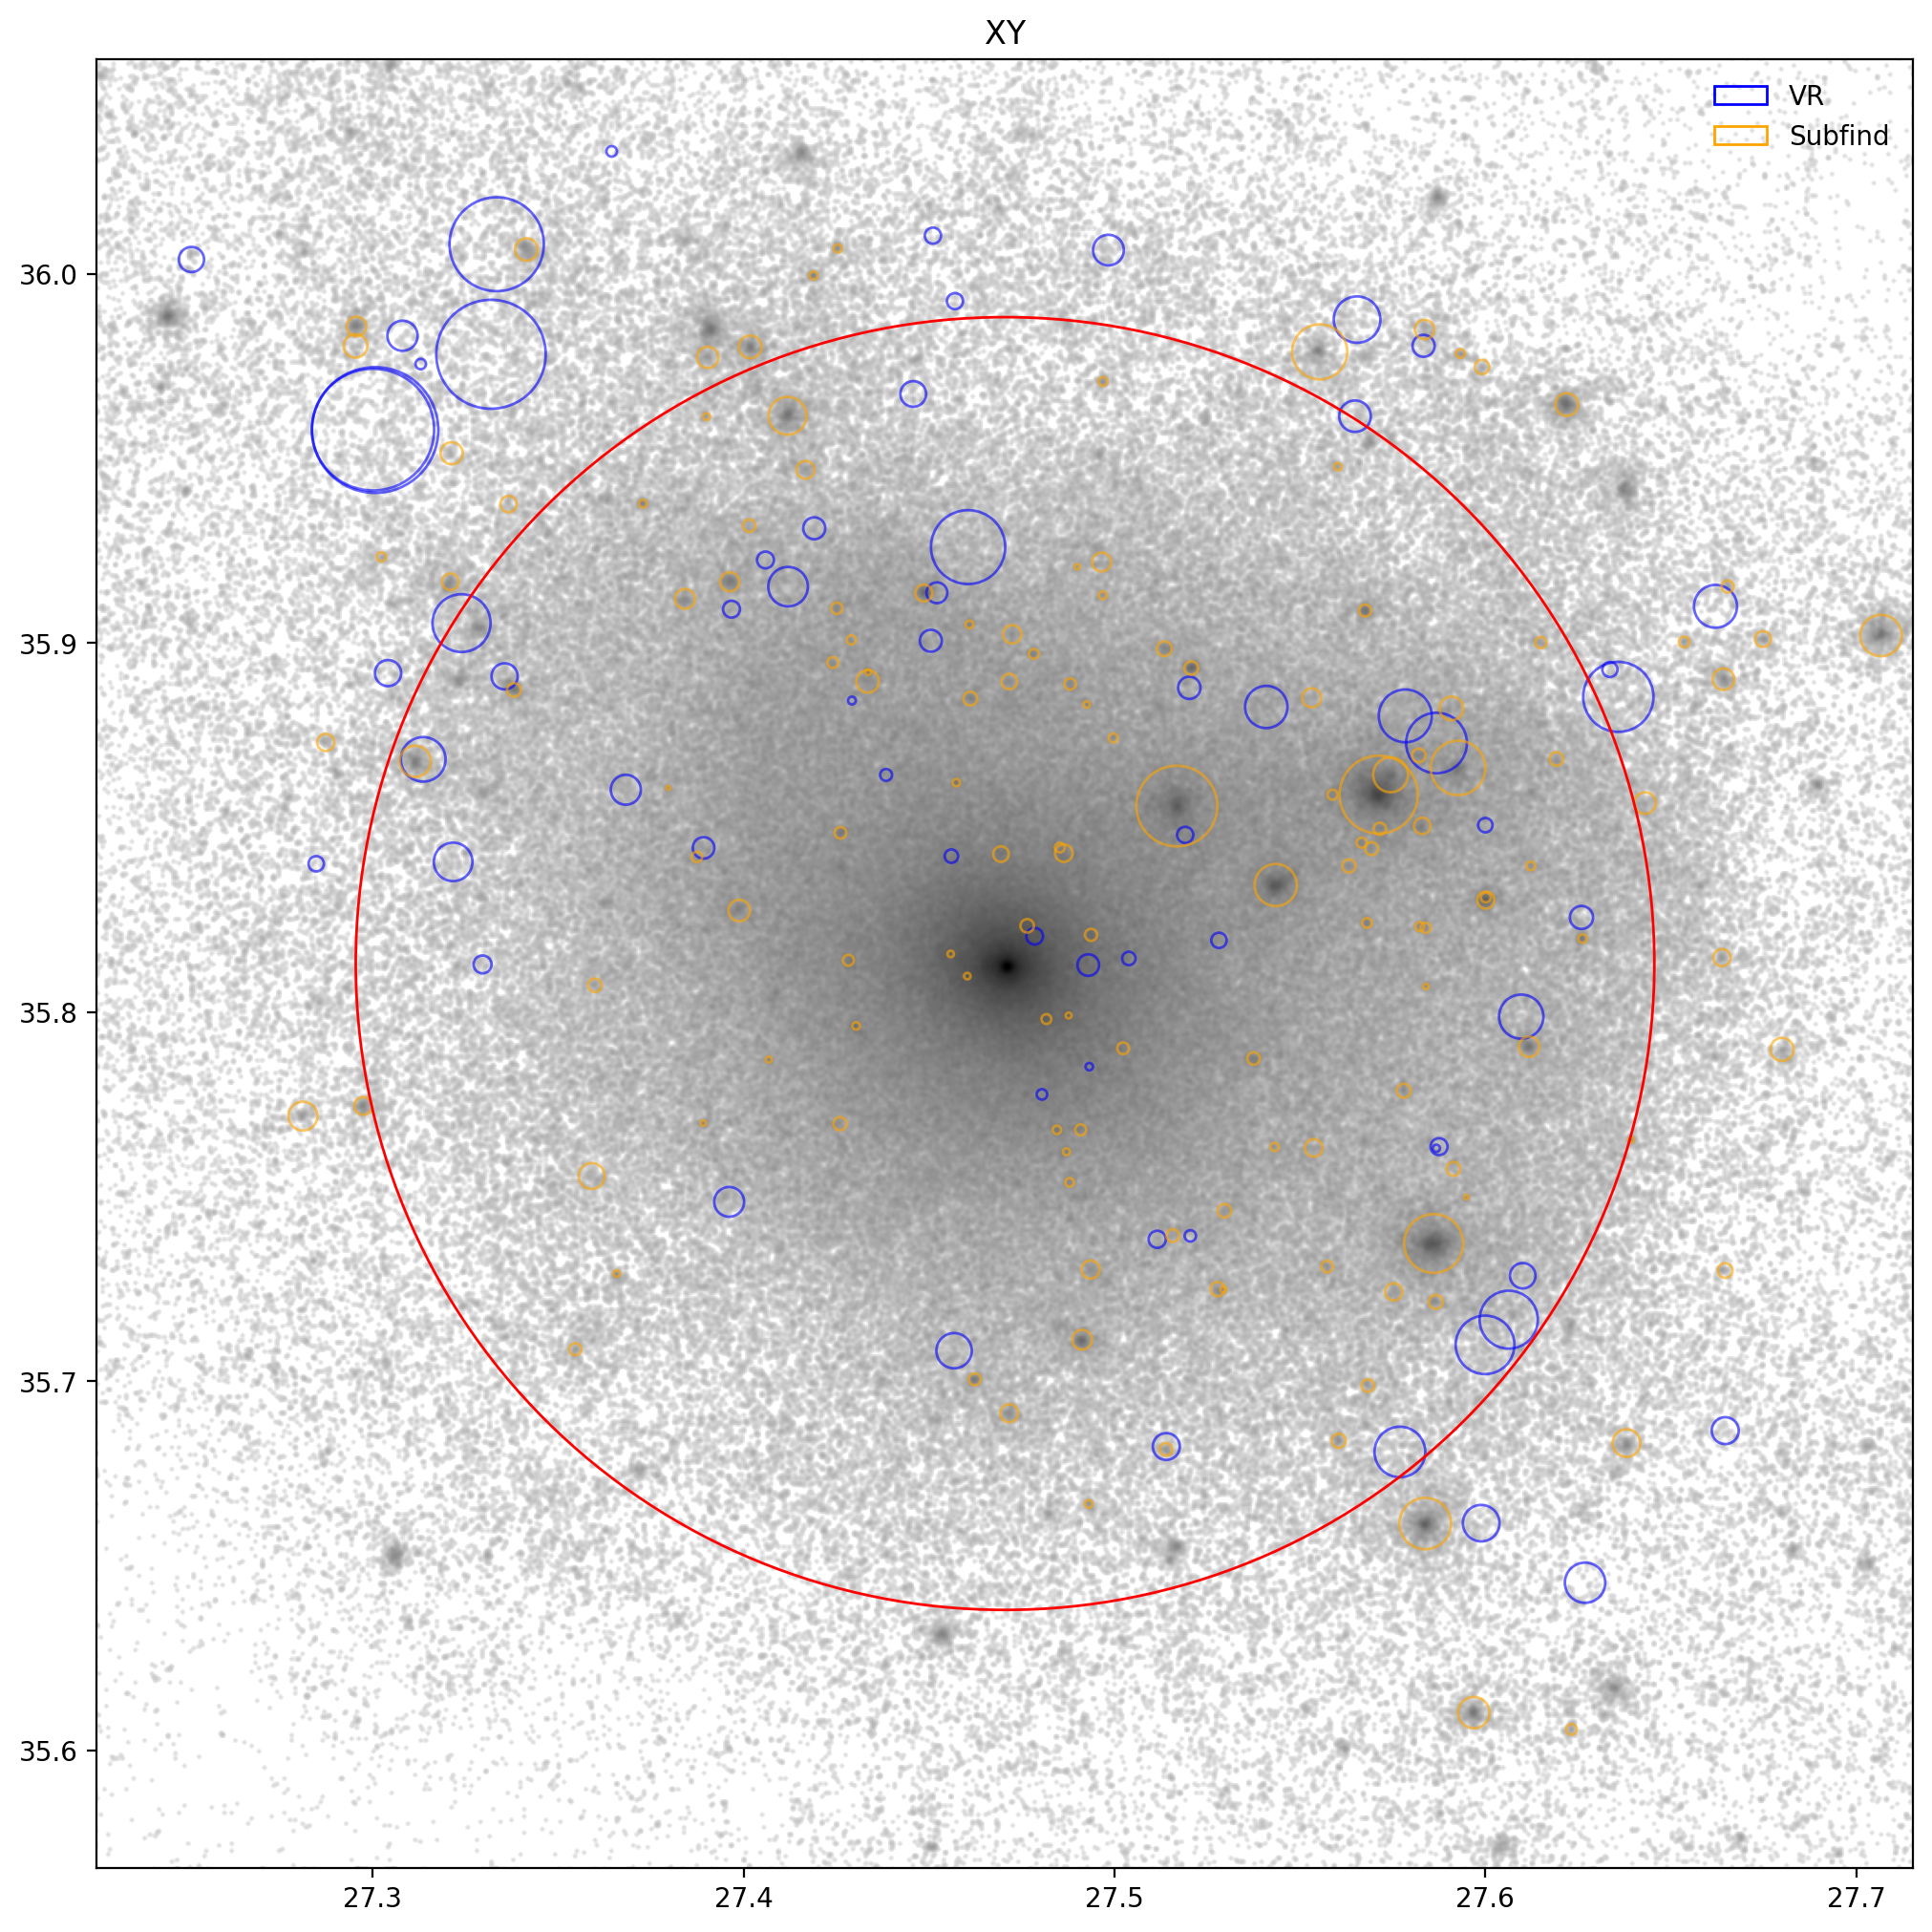

In [16]:
import scipy.stats

xmin, ymin, zmin = all_pos[:,0].min(), all_pos[:,1].min(), all_pos[:,2].min()
xmax, ymax, zmax = all_pos[:,0].max(), all_pos[:,1].max(), all_pos[:,2].max()
vmin, vmax = 1e5, 1e9

cmap = mpl.cm.get_cmap('gray_r')

# fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(10,4),dpi=200,layout='constrained')
fig, (ax1) = plt.subplots(1,1,figsize=(10,10),dpi=200,layout='constrained')
# fig, (ax1) = plt.subplots(figsize=(15,10))
nbins_heatmap = 1000
## particle background

# part_hist_xy, edges_x,edges_y = np.histogram2d(all_pos[:,0],all_pos[:,1],bins=400,weights=all_mass)
# edges = np.array((np.min(edges_x),np.max(edges_x),np.min(edges_y),np.max(edges_y)))
# ax1.imshow(np.transpose(part_hist_xy),extent=edges,norm=mpl.colors.LogNorm(vmin=1e5,vmax=1e9),origin='lower',cmap=cmap,alpha=1) 

# part_hist_xz, edges_x,edges_z = np.histogram2d(all_pos[:,0],all_pos[:,2],bins=400,weights=all_mass)
# edges = np.array((np.min(edges_x),np.max(edges_x),np.min(edges_z),np.max(edges_z)))
# ax2.imshow(np.transpose(part_hist_xz),extent=edges,norm=mpl.colors.LogNorm(vmin=1e5,vmax=1e9),origin='lower',cmap=cmap,alpha=1) 

# part_hist_yz, edges_y,edges_z = np.histogram2d(all_pos[:,1],all_pos[:,2],bins=400,weights=all_mass)
# edges = np.array((np.min(edges_y),np.max(edges_y),np.min(edges_z),np.max(edges_z)))
# ax3.imshow(np.transpose(part_hist_yz),extent=edges,norm=mpl.colors.LogNorm(vmin=1e5,vmax=1e9),origin='lower',cmap=cmap,alpha=1) 
sigma = 1
heatmap_xy, _, _ = np.histogram2d(all_pos[:,0],all_pos[:,1], bins=nbins_heatmap, range=[[xmin, xmax], [ymin, ymax]],weights=all_mass)
heatmap_xy_convolution = scipy.ndimage.gaussian_filter(heatmap_xy, sigma=sigma, order=0, mode="wrap")
ax1.imshow(heatmap_xy_convolution.T, origin="lower", extent=[xmin, xmax, ymin, ymax], cmap=cmap, norm=mpl.colors.LogNorm(vmin=vmin,vmax=vmax), aspect="auto")

# heatmap_xz, _, _ = np.histogram2d(all_pos[:,0],all_pos[:,2], bins=nbins_heatmap, range=[[xmin, xmax], [zmin, zmax]],weights=all_mass)
# heatmap_xz_convolution = scipy.ndimage.gaussian_filter(heatmap_xz, sigma=sigma, order=0, mode="wrap")
# ax2.imshow(heatmap_xz_convolution.T, origin="lower", extent=[xmin, xmax, zmin, zmax], cmap=cmap, norm=mpl.colors.LogNorm(vmin=vmin,vmax=vmax), aspect="auto")

# heatmap_yz, _, _ = np.histogram2d(all_pos[:,1],all_pos[:,2], bins=nbins_heatmap, range=[[ymin, ymax], [zmin, zmax]],weights=all_mass)
# heatmap_yz_convolution = scipy.ndimage.gaussian_filter(heatmap_yz, sigma=sigma, order=0, mode="wrap")
# ax3.imshow(heatmap_yz_convolution.T, origin="lower", extent=[ymin, ymax, zmin, zmax], cmap=cmap, norm=mpl.colors.LogNorm(vmin=vmin,vmax=vmax), aspect="auto")


for i in range(len(vr_sub_x_pos_cm)):
    ax1.add_patch(plt.Circle((vr_sub_x_pos_cm[i],vr_sub_y_pos_cm[i]),vr_sub_rad[i],fill=False,color='blue',alpha=0.6))
    # ax2.add_patch(plt.Circle((vr_sub_x_pos_cm[i],vr_sub_z_pos_cm[i]),vr_sub_rad[i],fill=False,color='blue',alpha=0.6))
    # ax3.add_patch(plt.Circle((vr_sub_y_pos_cm[i],vr_sub_z_pos_cm[i]),vr_sub_rad[i],fill=False,color='blue',alpha=0.6))
print(f"Num Velociraptor subhaloes = {len(vr_sub_x_pos_cm)}")

for i in range(len(subhalo_pos_cdm_010)):
    ax1.add_patch(plt.Circle((subhalo_pos_cdm_010[i,0]*LITTLEH,subhalo_pos_cdm_010[i,1]*LITTLEH),subhalo_radius_cdm_010[i],fill=False,color='orange',alpha=0.6))
    # ax2.add_patch(plt.Circle((subhalo_pos_cdm_010[i,0]*LITTLEH,subhalo_pos_cdm_010[i,2]*LITTLEH),subhalo_radius_cdm_010[i],fill=False,color='orange',alpha=0.6))
    # ax3.add_patch(plt.Circle((subhalo_pos_cdm_010[i,1]*LITTLEH,subhalo_pos_cdm_010[i,2]*LITTLEH),subhalo_radius_cdm_010[i],fill=False,color='orange',alpha=0.6))
print(f"Num Subfind subhaloes = {len(subhalo_pos_cdm_010)}")

ax1.set_title('XY')
# ax2.set_title('XZ')
# ax3.set_title('YZ')

import matplotlib.patches as patches
VR_legend = patches.Patch(color='blue',label='VR',fill=False)
SF_legend = patches.Patch(color='orange',label='Subfind',fill=False)
ax1.legend(handles=[VR_legend,SF_legend],frameon=False)
# ax_gce = ax1.axes()
# leg = ax_gce.get_legend()
# leg.legendHandles[0].set_color('blue')
# leg.legendHandles[1].set_color('orange')
# plt.legend(('Velociraptor','SubFind'))
# plt.legend()

### Plot centre point and radii
# plt.scatter(vel_halo_data['Xc'][test_id], vel_halo_data['Yc'][test_id],c='lime',s=1.5)
# rad = vel_halo_data["R_200crit"][test_id]
# plt.scatter(vel_halo_data['Xcminpot'][test_id], vel_halo_data['Ycminpot'][test_id],c='lime',s=1.5)
# ax.add_patch(plt.Circle((vel_halo_data['Xcminpot'][test_id], vel_halo_data['Ycminpot'][test_id]),rad, fill=False,color='lime',alpha=0.9))

### Plot subfind centre (27.4705, 35.8131, 32.2210)
ax1.add_patch(plt.Circle((27.47050095, 35.81316757),0.175091, fill=False,color='red',alpha=1))
# ax2.add_patch(plt.Circle((27.47050095, 32.2210),0.175091, fill=False,color='red',alpha=1))
# ax3.add_patch(plt.Circle((35.8131, 32.2210),0.175091, fill=False,color='red',alpha=1))
# plt.xlim((27.285,27.65))
# plt.ylim((35.63,36))